2019-09-25 23:28:45.119764 0.475311325521297 1253489343.119764


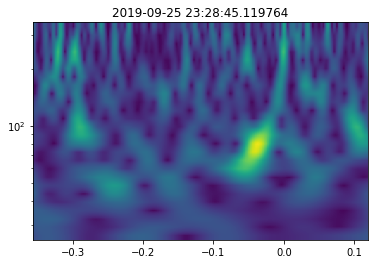

In [7]:
import glob, h5py
from pycbc.types import load_frequencyseries
from pycbc.detector import Detector
from pycbc.waveform.spa_tmplt import spa_length_in_time
import astropy.time
from pycbc.conversions import mtotal_from_mchirp_eta

ifos = ['H1', 'L1', 'V1']
dets = {}
for ifo in ifos:
    dets[ifo] = Detector(ifo)

fnames = glob.glob('/work/yifan.wang/4ogc/release_prod/convertsnr/1212_posterior/*190925*.hdf')
#fnames = glob.glob('../allposterior//*.hdf')
o.close()
o = h5py.File('qsave.hdf', 'w')

for fname in fnames:
    f = h5py.File(fname, 'r')
    ttime = f.attrs['trigger_time']
    logl = f['samples/loglikelihood'][:].argmax()
    ttime += f['samples/delta_tc'][logl]
    
    #if ttime != 1248112066.4472337:
    #    continue
    
    try:
        srcmchirp = f['samples/srcmchirp'][logl]
        mt = mtotal_from_mchirp_eta(srcmchirp, 0.25)
    except:
        mt = f['samples/srcmtotal'][logl]
    
    try:
        z = f['samples/redshift'][logl]
    except:
        z = 0
        
    mt = mt * (1 + z)
    dur = spa_length_in_time(mass1=mt / 2, mass2=mt / 2, phase_order=-1, f_lower=30.0)
    dur = dur if dur > 0.25 else 0.25
    dur = 5 if dur > 5 else dur
    
    try:
        ra = f['samples/ra'][logl]
        dec = f['samples/dec'][logl]
    except:
        ra = f.attrs['ra']
        dec = f.attrs['dec']
        
    pol = 0
    
    wstotal = None   
    vkeys = list(f['data'].keys())
    #vkeys = ['H1']
    
    for ifo in vkeys:
        fs = load_frequencyseries(fname, group='data/{}/stilde'.format(ifo))  

        dt = dets[ifo].time_delay_from_earth_center(ra, dec, ttime)
        fp, fc = dets[ifo].antenna_pattern(ra, dec, pol, ttime)
        dfac = fp - 1.0j * fc  # We are simplifying the inclination / polarization info here
        
        fs = fs / dfac
        ts = fs.to_timeseries().cyclic_time_shift(-dt)
        ts.start_time -= dt
        
        ws = (ts.to_frequencyseries() / ts.filter_psd(2, ts.delta_f, 20.0)).to_timeseries()
        
        if wstotal is None:
            wstotal = ws
        else:
            wstotal = wstotal.add_into(ws)
            
    wst = wstotal.whiten(2, 2)
    t = astropy.time.Time(ttime, format='gps', scale='utc')
    import pylab
    
    qval = 8
    if dur > 0.25:
        qval = 10
    if dur > 1.0:
        qval = 20
    if dur > 1.5:
        qval = 30
    if dur > 2.5:
        qval = 50
    if dur >= 5:
        qval = 95
    

    print(t.datetime, dur, ttime)
    
    wst = wst.time_slice(ttime - dur * 2 - 2, ttime + 2)
    times, freqs, power = wst.qtransform(.001, logfsteps=400,
                                        qrange=(qval, qval),
                                        frange=(25, 350))
    
    o.create_dataset('{}/times'.format(ttime), data=times)
    o.create_dataset('{}/freqs'.format(ttime), data=freqs)
    o.create_dataset('{}/power'.format(ttime), data=power)
    o[str(ttime)].attrs['dur'] = dur
    pylab.figure()
    #pylab.text(-dur * 4/5.0, 200, t.datetime)
    pylab.title(t.datetime)
    pylab.pcolormesh(times - ttime, freqs, power**0.5, vmax=5)
    pylab.yscale('log')
    pylab.xlim(- dur * 0.75, dur * 0.25)
    
o.close()